In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Arsenal 2-3 Manchester United - Premier League 2025_2026 Live.html"
fotmob_matchId = 4813596

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [4]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'isOwnGoal', 'isGoal',
       'cardType'],
      dtype='object')

In [5]:
dfp.columns

Index(['playerId', 'shirtNo', 'name', 'position', 'height', 'weight', 'age',
       'isFirstEleven', 'isManOfTheMatch', 'field', 'stats',
       'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
       'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
       'teamId', 'shortName'],
      dtype='object')

In [6]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [7]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [8]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [9]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [10]:
df = df.merge(dfp, on='playerId', how='left')

In [11]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'isOwnGoal', 'isGoal', 'cardType',
       'teamName', 'oppositionTeamName', 'shirtNo', 'name', 'position',
       'isFirstEleven', 'shortName'],
      dtype='object')

In [12]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,isOwnGoal,isGoal,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.892915e+09,3,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,NaN,NaN,NaN,NaN,NaN
1,2.892915e+09,3,0,0.0,13,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,NaN,NaN,NaN,NaN,NaN
2,2.892915e+09,4,0,0.0,32,60.24,40.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,8.0,Bruno Fernandes,AMC,True,B. Fernandes
3,2.892915e+09,5,0,3.0,32,36.00,38.24,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,31.0,Senne Lammens,GK,True,S. Lammens
4,2.892915e+09,4,0,7.0,13,28.68,16.00,0,NaN,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,36.0,Martín Zubimendi,MC,True,M. Zubimendi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,2.893010e+09,802,97,57.0,13,0.00,0.00,100,NaN,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,NaN,NaN,NaN,NaN,NaN
1375,2.893010e+09,685,0,0.0,32,0.00,0.00,10,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,NaN,NaN,NaN,NaN,NaN
1376,2.893010e+09,803,0,0.0,13,0.00,0.00,10,NaN,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,NaN,NaN,NaN,NaN,NaN
1377,2.892854e+09,2,0,0.0,13,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,NaN,NaN,NaN,NaN,NaN


In [13]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,276366,1,David Raya,GK,True,D. Raya
1,388650,12,Jurriën Timber,DR,True,J. Timber
2,334087,6,Gabriel Magalhães,DC,True,G. Magalhães
3,361822,2,William Saliba,DC,True,W. Saliba
4,404832,5,Piero Hincapié,DL,True,P. Hincapié
5,247454,8,Martin Ødegaard,MC,True,M. Ødegaard
6,372424,36,Martín Zubimendi,MC,True,M. Zubimendi
7,332325,41,Declan Rice,MC,True,D. Rice
8,367185,7,Bukayo Saka,FWR,True,B. Saka
9,279379,9,Gabriel Jesus,FW,True,G. Jesus


In [14]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [15]:
df=df.reset_index()

In [16]:
df

,index,id,eventId,minute,second,teamId,x,y,expandedMinute,period,...,isOwnGoal,isGoal,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2,2.892915e+09,4,0,0.0,32,60.24,40.00,0,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,8.0,Bruno Fernandes,AMC,True,B. Fernandes
1,3,2.892915e+09,5,0,3.0,32,36.00,38.24,0,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,31.0,Senne Lammens,GK,True,S. Lammens
2,6,2.892915e+09,5,0,7.0,13,28.68,16.00,0,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,36.0,Martín Zubimendi,MC,True,M. Zubimendi
3,7,2.892916e+09,8,0,18.0,32,89.28,80.00,0,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,23.0,Luke Shaw,DL,True,L. Shaw
4,8,2.892916e+09,9,0,25.0,32,75.84,73.68,0,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,6.0,Lisandro Martínez,DC,True,L. Martínez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,1364,2.893009e+09,678,96,46.0,32,6.48,24.32,99,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,31.0,Senne Lammens,GK,True,S. Lammens
947,1366,2.893009e+09,799,96,57.0,13,76.80,76.72,99,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,41.0,Declan Rice,MC,True,D. Rice
948,1368,2.893009e+09,680,96,58.0,32,42.96,22.08,99,NaN,...,NaN,NaN,NaN,Man Utd,Arsenal,37.0,Kobbie Mainoo,DMC,True,K. Mainoo
949,1369,2.893009e+09,800,97,3.0,13,26.52,60.72,100,NaN,...,NaN,NaN,NaN,Arsenal,Man Utd,1.0,David Raya,GK,True,D. Raya


In [17]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [18]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,60.24,40.00,33.48,39.76,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
1,0,3.0,36.00,38.24,91.32,64.00,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN
2,0,7.0,28.68,16.00,30.36,0.00,Arsenal,36.0,MC,M. Zubimendi,NaN,NaN,NaN
3,0,18.0,89.28,80.00,72.24,71.44,Man Utd,23.0,DL,L. Shaw,NaN,NaN,NaN
4,0,25.0,75.84,73.68,105.12,37.04,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,96,46.0,6.48,24.32,83.04,10.08,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN
947,96,57.0,76.80,76.72,78.48,75.36,Arsenal,41.0,MC,D. Rice,NaN,NaN,NaN
948,96,58.0,42.96,22.08,95.76,18.16,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
949,97,3.0,26.52,60.72,101.16,54.00,Arsenal,1.0,GK,D. Raya,NaN,NaN,NaN


In [19]:
df.to_csv('players.csv', index=False)

In [20]:
df.shortName.unique()

array(['B. Fernandes', 'S. Lammens', 'M. Zubimendi', 'L. Shaw',
       'L. Martínez', 'G. Magalhães', 'P. Hincapié', 'D. Dalot',
       'M. Ødegaard', 'G. Jesus', 'L. Trossard', 'W. Saliba', 'J. Timber',
       'B. Saka', 'D. Raya', 'H. Maguire', 'B. Mbeumo', 'D. Rice',
       'Casemiro', 'K. Mainoo', 'A. Diallo', 'P. Dorgu', 'M. Merino',
       'B. White', 'E. Eze', 'V. Gyökeres', 'M. Cunha', 'N. Madueke',
       'B. Sesko'], dtype=object)

In [21]:
#Bruno Data
df_8=df[df["shortName"]=="B. Fernandes"].reset_index()
df_8

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0,0.0,60.24,40.00,33.48,39.76,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
1,29,2,59.0,53.04,72.72,37.08,76.08,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
2,138,13,17.0,55.56,58.16,51.00,64.48,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
3,149,14,1.0,51.72,60.08,53.40,50.08,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
4,155,14,14.0,9.36,60.08,17.52,55.04,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
5,157,14,18.0,8.52,67.04,28.68,72.96,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
6,191,18,35.0,15.72,47.44,49.20,68.56,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
7,220,22,7.0,68.52,75.60,59.28,62.56,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
8,235,22,56.0,64.32,35.68,64.80,30.88,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
9,237,23,4.0,65.52,40.00,67.68,45.84,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN


In [22]:
#Mbeumo Data
df_19=df[df["shortName"]=="B. Mbeumo"].reset_index()
df_19

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,33,3,10.0,57.84,39.28,51.36,39.04,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
1,49,4,32.0,73.92,56.48,78.12,61.76,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
2,196,19,29.0,87.24,12.96,90.24,17.68,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
3,256,24,18.0,57.00,26.24,54.96,17.76,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
4,284,25,55.0,52.80,10.32,37.92,2.56,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
5,289,26,11.0,53.52,3.92,45.84,20.48,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
6,341,30,25.0,113.16,56.64,96.84,52.48,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
7,372,33,16.0,89.88,28.64,104.76,45.52,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
8,406,36,31.0,104.52,38.16,NaN,NaN,Man Utd,19.0,FW,B. Mbeumo,39.92,True,True
9,429,41,34.0,82.92,30.08,93.12,38.80,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN


In [23]:
#Dorgu Data
df_13=df[df["shortName"]=="P. Dorgu"].reset_index()
df_13

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,137,13,16.0,68.88,68.56,55.56,58.16,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
1,229,22,29.0,106.08,63.68,105.60,56.00,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
2,271,25,14.0,36.72,62.56,39.48,50.64,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
3,273,25,18.0,41.28,71.76,29.04,65.84,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
4,293,26,23.0,90.12,77.04,80.64,66.64,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
5,295,26,25.0,80.64,73.44,57.60,53.04,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
6,297,26,32.0,58.08,70.24,28.32,53.12,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
7,327,28,32.0,9.00,49.84,9.00,61.04,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
8,360,32,27.0,85.08,53.04,89.88,32.72,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
9,441,42,44.0,51.72,72.24,51.00,56.88,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN


In [24]:
#Mainoo Data
df_37=df[df["shortName"]=="K. Mainoo"].reset_index()
df_37

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,121,11,26.0,36.36,30.88,44.52,15.04,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
1,139,13,18.0,51.36,64.00,36.12,17.28,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
2,141,13,32.0,54.60,51.20,48.24,62.24,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
3,156,14,16.0,17.40,56.24,7.92,66.40,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
4,209,21,17.0,46.44,58.88,47.88,76.96,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
5,211,21,22.0,48.72,61.52,36.96,27.44,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
6,217,21,56.0,48.72,21.92,42.36,48.96,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
7,223,22,18.0,82.80,21.68,90.84,8.32,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
8,226,22,23.0,88.44,24.48,83.76,44.32,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
9,231,22,40.0,91.80,36.48,NaN,NaN,Man Utd,37.0,DMC,K. Mainoo,40.16,True,NaN


In [25]:
#Cunha Data
df_10=df[df["shortName"]=="M. Cunha"].reset_index()
df_10

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,726,70,54.0,83.04,63.28,76.44,61.52,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
1,728,70,56.0,88.32,61.60,73.44,60.32,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
2,746,71,50.0,111.48,58.08,112.32,40.80,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
3,748,71,52.0,110.16,50.88,104.76,60.00,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
4,815,78,2.0,81.00,62.08,71.88,74.08,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
5,849,83,11.0,0.72,40.24,3.12,41.20,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
6,863,86,10.0,89.28,40.08,NaN,NaN,Man Utd,10.0,Sub,M. Cunha,36.88,True,True
7,888,89,33.0,37.68,42.48,29.28,38.24,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
8,929,94,27.0,76.80,63.04,69.48,57.68,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN


C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\2307102729.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


54


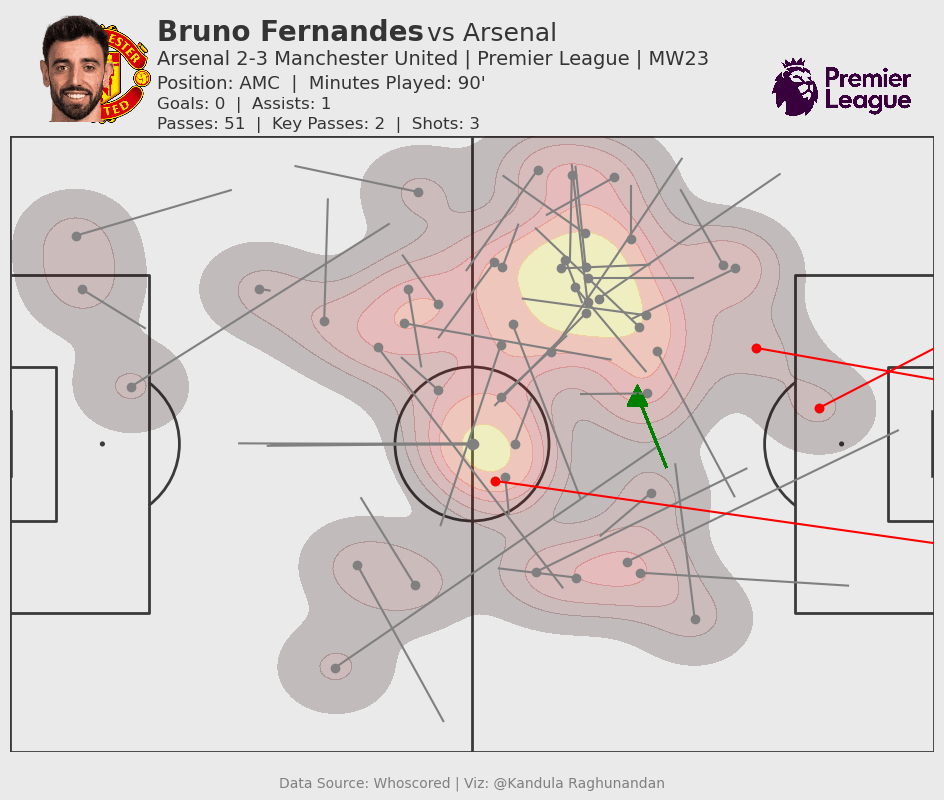

In [26]:
#Bruno Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_8, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Fernandes":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Fernandes") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][554]==True):
        plt.scatter(df["x"][553],df["y"][553],color="Green",marker="^",s=200)
        plt.plot((df["x"][553],df["endX"][553]),(df["y"][553],df["endY"][553]),color="Green")
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Fernandes"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Bruno Fernandes", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.475,1,"vs Arsenal", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Arsenal 2-3 Manchester United | Premier League | MW23", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AMC  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Bruno Fernandes.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 51  |  Key Passes: 2  |  Shots: 3", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Arsenal 2-3 Manchester United - Premier League 2025_2026 Live_files\New folder\Bruno.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\3391289530.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


16


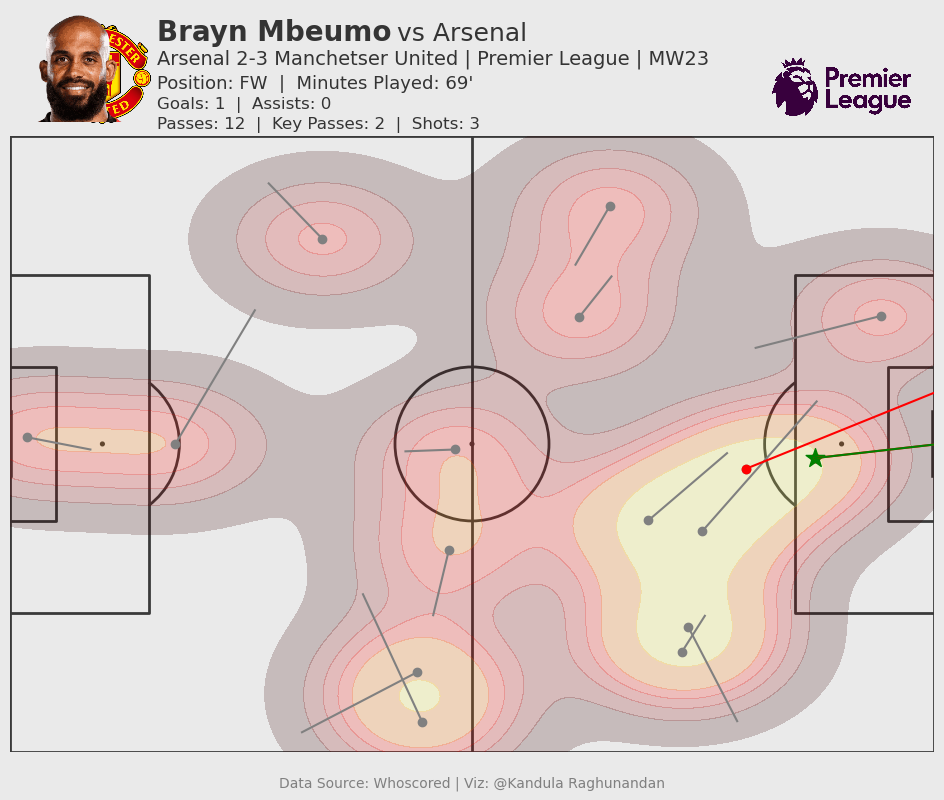

In [27]:
#Mbeumo Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_19, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Mbeumo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Mbeumo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][821]==True):
        #plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Mbeumo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Brayn Mbeumo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.45,1,"vs Arsenal", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Arsenal 2-3 Manchetser United | Premier League | MW23", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: FW  |  Minutes Played: 69'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mbeumo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 12  |  Key Passes: 2  |  Shots: 3", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Arsenal 2-3 Manchester United - Premier League 2025_2026 Live_files\New folder\Mbeumo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\2803568555.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


24


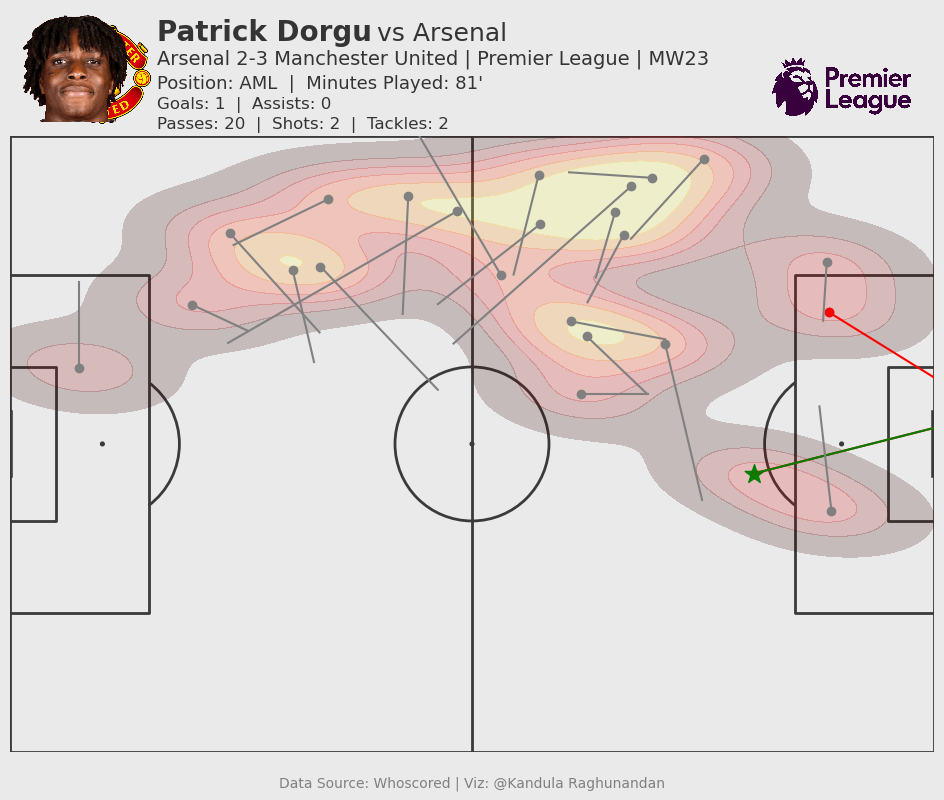

In [28]:
#Dorgu Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_13, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="P. Dorgu":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="P. Dorgu") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][821]==True):
        #plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="P. Dorgu"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Patrick Dorgu", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.433,1,"vs Arsenal", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Arsenal 2-3 Manchester United | Premier League | MW23", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AML  |  Minutes Played: 81'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Dorgu.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 20  |  Shots: 2  |  Tackles: 2", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Arsenal 2-3 Manchester United - Premier League 2025_2026 Live_files\New folder\Dorgu.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\2925147656.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


46


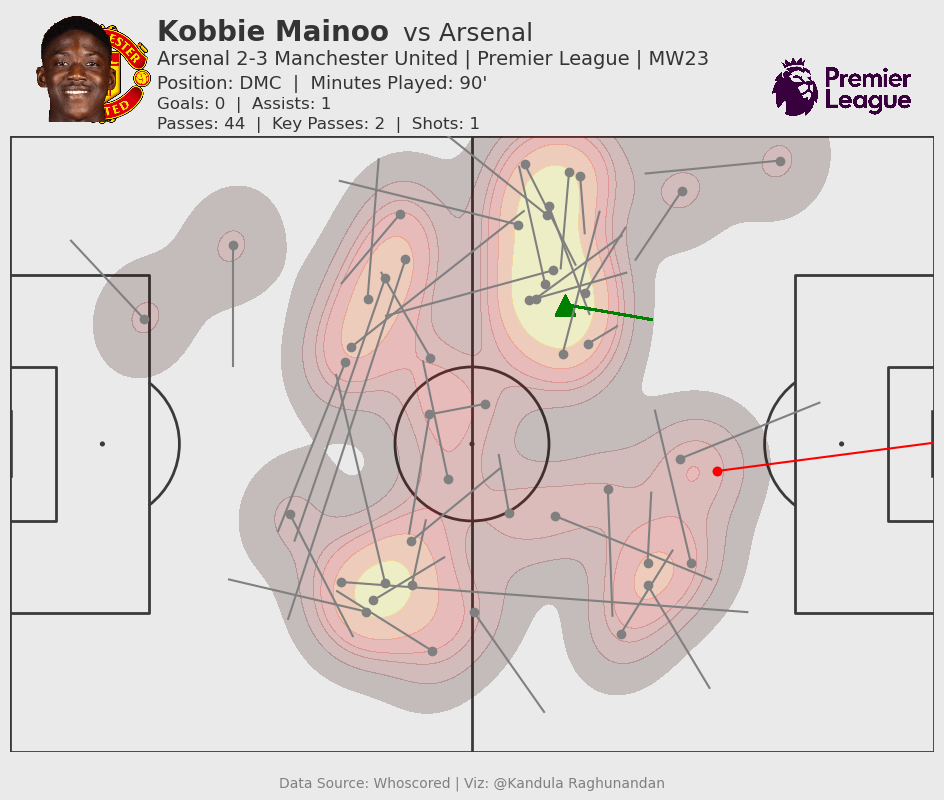

In [29]:
#Mainoo Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_37, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="K. Mainoo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="K. Mainoo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][863]==True):
        plt.scatter(df["x"][862],df["y"][862],color="Green",marker="^",s=200)
        plt.plot((df["x"][862],df["endX"][862]),(df["y"][862],df["endY"][862]),color="Green")
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="K. Mainoo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Kobbie Mainoo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.455,1,"vs Arsenal", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Arsenal 2-3 Manchester United | Premier League | MW23", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DMC  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mainoo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 44  |  Key Passes: 2  |  Shots: 1", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Arsenal 2-3 Manchester United - Premier League 2025_2026 Live_files\New folder\Mainoo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\2486539160.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


9


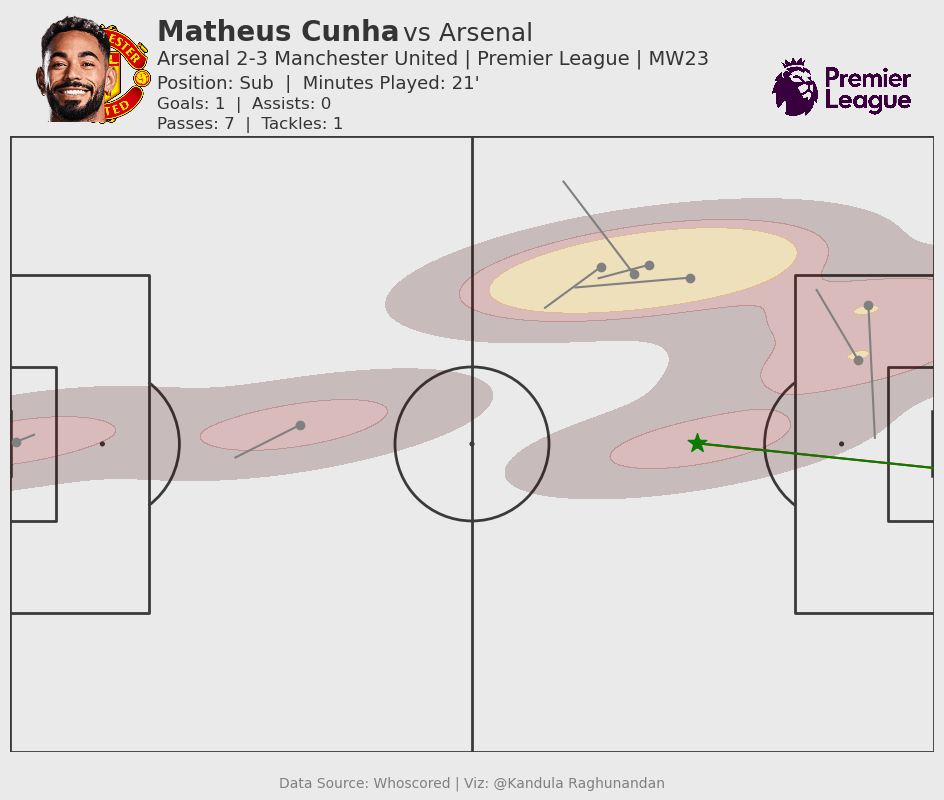

In [30]:
#Cunha Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_10, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=4,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="M. Cunha":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="M. Cunha") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][914]==True):
    #   plt.scatter(df["x"][913],df["y"][913],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="M. Cunha"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Matheus Cunha", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.455,1,"vs Arsenal", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Arsenal 2-3 Manchester United | Premier League | MW23", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: Sub  |  Minutes Played: 21'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Cunha.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 7  |  Tackles: 1", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Arsenal 2-3 Manchester United - Premier League 2025_2026 Live_files\New folder\Cunha.jpg",bbox_inches='tight')

In [31]:
#Passing Networks

In [32]:
df.columns

Index(['minute', 'second', 'x', 'y', 'endX', 'endY', 'teamName', 'shirtNo',
       'position', 'shortName', 'goalMouthY', 'isShot', 'isGoal'],
      dtype='object')

In [33]:
df_mun=df[df["teamName"]=="Man Utd"].reset_index()
df_mun

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0,0.0,60.24,40.00,33.48,39.76,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
1,1,0,3.0,36.00,38.24,91.32,64.00,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN
2,3,0,18.0,89.28,80.00,72.24,71.44,Man Utd,23.0,DL,L. Shaw,NaN,NaN,NaN
3,4,0,25.0,75.84,73.68,105.12,37.04,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN
4,7,0,47.0,69.60,0.00,82.56,10.72,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,939,95,13.0,25.92,53.04,38.40,60.24,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN
416,944,95,41.0,7.32,51.60,9.96,72.96,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN
417,946,96,46.0,6.48,24.32,83.04,10.08,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN
418,948,96,58.0,42.96,22.08,95.76,18.16,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN


In [34]:
firstSub=69

In [35]:
df_mun=df_mun[df_mun["minute"]<firstSub]
df_mun

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0,0.0,60.24,40.00,33.48,39.76,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
1,1,0,3.0,36.00,38.24,91.32,64.00,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN
2,3,0,18.0,89.28,80.00,72.24,71.44,Man Utd,23.0,DL,L. Shaw,NaN,NaN,NaN
3,4,0,25.0,75.84,73.68,105.12,37.04,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN
4,7,0,47.0,69.60,0.00,82.56,10.72,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,683,66,10.0,62.76,45.60,68.16,57.60,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
319,684,66,13.0,67.44,58.64,80.04,62.24,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
320,697,66,56.0,8.88,39.92,23.40,38.80,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN
321,698,66,57.0,21.48,40.00,31.80,57.36,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN


In [36]:
df_mun["passer"]=df_mun["shirtNo"]
df_mun["recipient"]=df_mun["shirtNo"].shift(-1)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\1171812944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["passer"]=df_mun["shirtNo"]
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\1171812944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["recipient"]=df_mun["shirtNo"].shift(-1)


In [37]:
df_mun

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,0,0,0.0,60.24,40.00,33.48,39.76,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN,8.0,31.0
1,1,0,3.0,36.00,38.24,91.32,64.00,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN,31.0,23.0
2,3,0,18.0,89.28,80.00,72.24,71.44,Man Utd,23.0,DL,L. Shaw,NaN,NaN,NaN,23.0,6.0
3,4,0,25.0,75.84,73.68,105.12,37.04,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN,6.0,2.0
4,7,0,47.0,69.60,0.00,82.56,10.72,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN,2.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,683,66,10.0,62.76,45.60,68.16,57.60,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN,18.0,37.0
319,684,66,13.0,67.44,58.64,80.04,62.24,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN,37.0,5.0
320,697,66,56.0,8.88,39.92,23.40,38.80,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN,5.0,19.0
321,698,66,57.0,21.48,40.00,31.80,57.36,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN,19.0,31.0


In [38]:
df_mun.to_csv("player.csv")

In [39]:
pas=pd.to_numeric(df_mun["passer"],downcast="integer")
rec=pd.to_numeric(df_mun["recipient"],downcast="integer")

df_mun["passer"]=pas
df_mun["recipient"]=rec

df_mun.head()

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\2514975927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["passer"]=pas
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10620\2514975927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["recipient"]=rec


,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,0,0,0.0,60.24,40.00,33.48,39.76,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN,8,31.0
1,1,0,3.0,36.00,38.24,91.32,64.00,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN,31,23.0
2,3,0,18.0,89.28,80.00,72.24,71.44,Man Utd,23.0,DL,L. Shaw,NaN,NaN,NaN,23,6.0
3,4,0,25.0,75.84,73.68,105.12,37.04,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN,6,2.0
4,7,0,47.0,69.60,0.00,82.56,10.72,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN,2,6.0


In [40]:
df_mun=df_mun.drop(["goalMouthY","isShot","isGoal"],axis=1)

In [41]:
average_locations=df_mun.groupby("passer").agg({"x":["mean"],"y":["mean","count"]})
average_locations.columns=["x","y","count"]
average_locations.head()

,x,y,count
passer,,,
2,65.673333,8.346667,18
5,42.316667,27.724444,36
6,46.261176,54.138039,51
8,63.415385,50.348718,39
13,66.666000,62.324000,20


In [42]:
pass_between = (
    df_mun
    .groupby(["passer", "recipient"])
    .size()
    .reset_index(name="pass_count")
)

pass_between.head()

,passer,recipient,pass_count
0,2,5.0,2
1,2,6.0,3
2,2,8.0,1
3,2,16.0,2
4,2,18.0,4


In [43]:
pass_between = pass_between.merge(average_locations, left_on='passer', right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient', right_index=True, suffixes=['', '_end'])

pass_between.head()

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,2,5.0,2,65.673333,8.346667,18,42.316667,27.724444,36
1,2,6.0,3,65.673333,8.346667,18,46.261176,54.138039,51
2,2,8.0,1,65.673333,8.346667,18,63.415385,50.348718,39
3,2,16.0,2,65.673333,8.346667,18,64.440000,23.570909,22
4,2,18.0,4,65.673333,8.346667,18,49.602581,42.056774,31


In [44]:
pass_between=pass_between[pass_between["pass_count"]>3]
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
4,2,18.0,4,65.673333,8.346667,18,49.602581,42.056774,31
8,5,2.0,8,42.316667,27.724444,36,65.673333,8.346667,18
10,5,6.0,11,42.316667,27.724444,36,46.261176,54.138039,51
12,5,16.0,5,42.316667,27.724444,36,64.440000,23.570909,22
18,6,5.0,13,46.261176,54.138039,51,42.316667,27.724444,36
19,6,8.0,6,46.261176,54.138039,51,63.415385,50.348718,39
21,6,18.0,4,46.261176,54.138039,51,49.602581,42.056774,31
22,6,23.0,10,46.261176,54.138039,51,58.176923,71.240000,26
23,6,31.0,8,46.261176,54.138039,51,14.983448,42.540690,29
24,6,37.0,6,46.261176,54.138039,51,59.379429,43.524571,35


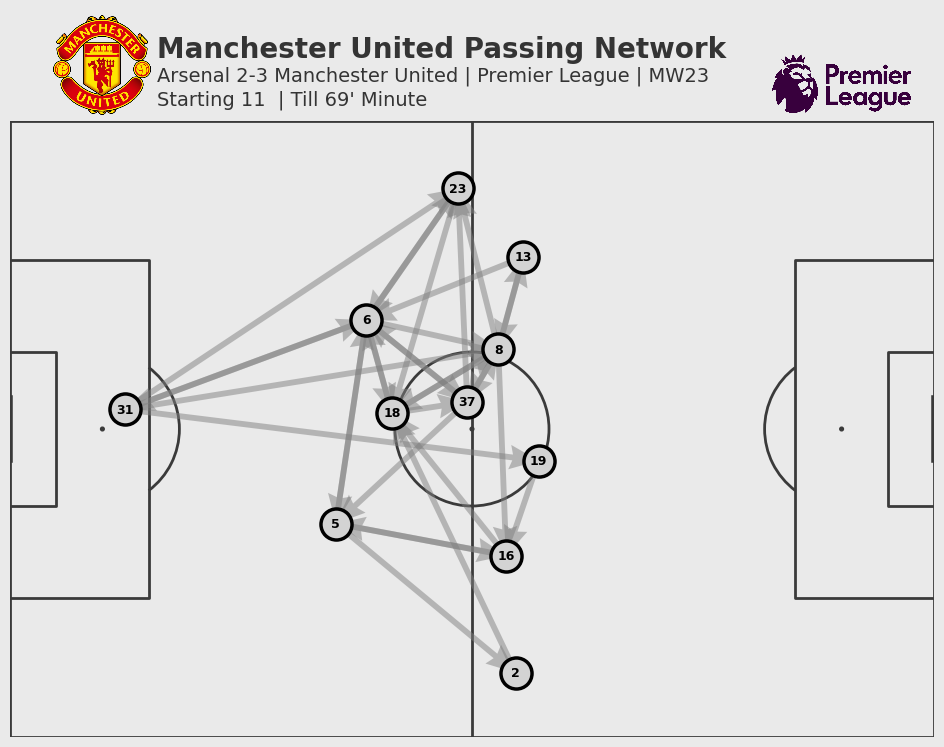

In [50]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

#Plotting Arrows
arrows=pitch.arrows(pass_between.x,
                    pass_between.y,
                    pass_between.x_end,
                    pass_between.y_end,
                    ax=ax,
                    width=4.2,
                    headwidth=4.2,
                    color="#808080",
                    alpha=.5)

#Plotting Scatter Points
nodes=pitch.scatter(average_locations.x,
                    average_locations.y,
                    s=500,
                    color="#d3d3d3",
                    edgecolor="black",
                    linewidth=2.5,
                    alpha=1,
                    ax=ax)

#Adding Player No. at Scatter Points
for passer, row in average_locations.iterrows():
    ax.text(
        row['x'],    # x position
        row['y'],    # y position
        str(passer),       # the index (playerId)
        ha='center', va='center',
        fontsize=9, color='black', weight='bold'
    )

fig.text(0.25, 0.96, "Manchester United Passing Network", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.25, 0.93, "Arsenal 2-3 Manchester United | Premier League | MW23",fontsize=14, color='#343434')
fig.text(0.25, 0.90, "Starting 11  | Till 69' Minute",fontsize=14, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.09))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.06))

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Arsenal 2-3 Manchester United - Premier League 2025_2026 Live_files\New folder\Passing_Network.jpg",bbox_inches='tight')